<section style="background-color: #21222c; padding: 1em">
    <h1><img alt="QuestDB Logo" src="https://questdb.io/img/questdb-logo.svg" width="305px"/></h1>
    <h2 style="color: white;">Interactive Notebook Session - Let's Play</h2>
</section>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg
import questdb.ingress as qi

In [2]:
# This demo relies on dynamic network ports for the core endpoints.
http_port = 50881  # Web Console and REST API
ilp_port = 59457  # Fast data ingestion port 
pg_port = 58493  # PostgreSQL-compatible endpoint

In this Jupyter Notebook you are going to experiment adding a time-series database to your Panda workflows, so you can:
* Execute filters, aggregations, and transforms directly on the database, with automatica parallelization and no memory restrictions,  to avoid Pandas constraints
* Downsample and interpolate data at speed
* Use SQL for a better developer experience

## A little bit of config before we start

We will be using QuestDB later in the notebook. QuestDB allows you to connect using the Postgresql protocol (port 8812), a REST API (port 8812) and ILP, a fast protocol for high throughput (port 9009). The ports for this demo have been dynamically assigned and matched the QuestDB instance started behind the scenes. **Please don't change these values**.

QuestDB allows you to control many different configuration parameters, but it should provide a good experience out of the box for small and moderate workloads. If you want to check the whole list of config parameteres available please refer to [the documentation](https://questdb.io/docs/reference/configuration/)

In [36]:
# This demo relies on dynamic network ports for the core endpoints. Please execute but don't modify this cell
qdb_user = 'admin'      # Default user name
qdb_password = 'quest'  # Default password
qdb_dbname = 'qdb'      # Default db name

## The dataset

The Open Power System Data (OPSD) hosts aggregated data about the energy landscape in some European countries. One of the datasets they curate contains energy data in 15 minutes intervals for Austria, Belgium, Germany, Hungary, Luxembourg, and Netherlands. The original can be found at https://data.open-power-system-data.org/time_series/

We find this dataset a very fitting one to get started with time-series processing, and we are providing a derivative dataset containing only four columns:

* Timestamp of the measure, in UTC timezone
* Actual total load in MW
* Forecasted energy for the same period, one day ahead, in MW
* Country code

To make the download smaller we filtered only data for 2018 and 2019 and compressed the dataset. The total number of rows is **413383**. If you want to check the transforms we did to the original data, please see https://gist.github.com/javier/e7ca50d7c3bf4e414e2af1f8c7d7b556

In [28]:
df = pd.read_parquet('energy_15_mins.parquet.gzip')

Let's see what's inside

In [29]:
df

,timestamp,load_actual,load_forecast,country_code
105220,2018-01-01 00:00:00,6060.40,6497.24,AT
105221,2018-01-01 00:15:00,5971.20,6399.35,AT
105222,2018-01-01 00:30:00,5875.20,6321.08,AT
105223,2018-01-01 00:45:00,5830.80,6252.09,AT
105224,2018-01-01 01:00:00,5872.00,6328.14,AT
...,...,...,...,...
175295,2019-12-31 22:45:00,11284.98,9672.61,NL
175296,2019-12-31 23:00:00,11185.59,9573.25,NL
175297,2019-12-31 23:15:00,11207.35,9593.16,NL
175298,2019-12-31 23:30:00,11237.45,9583.39,NL


And a quick check of column names and types

In [30]:
df.columns

Index(['timestamp', 'load_actual', 'load_forecast', 'country_code'], dtype='object')

In [31]:
df.dtypes

timestamp        datetime64[ns]
load_actual             float64
load_forecast           float64
country_code             object
dtype: object

## Inserting your dataframe into QuestDB

To ingest your dataframe into QuestDB, you use the Sender object. We need to specify the table name and the name of the column that will be the designated timestamp. If you don't specify one, ingestion time will be used.

In [33]:
with qi.Sender('localhost', ilp_port) as sender:
  sender.dataframe(df, table_name='energy_total', at='timestamp')
  

## Reading data

A good way of reading data is by using Psycopg and connecting to QuestDB using the postgres protocol. As a first query let's get all the data for each country aggregated in 6 months intervals, rather than the original 15 minutes resolution

In [49]:

params = dict(user=qdb_user, password=qdb_password, host='127.0.0.1', port=pg_port, dbname=qdb_dbname)
records = None
with psycopg.connect(**params) as conn:
    with conn.cursor() as cur:
        cur.execute("""\
                    SELECT timestamp, 
                    country_code, 
                    SUM(load_actual) as total_load, 
                    avg(load_actual) as average_load 
                    FROM energy_total 
                    SAMPLE by 6M
                    """)
        records = cur.fetchall()

ndf = pd.DataFrame(records, columns=['timestamp', 'country_code', 'total_mw', 'average_mw'] )

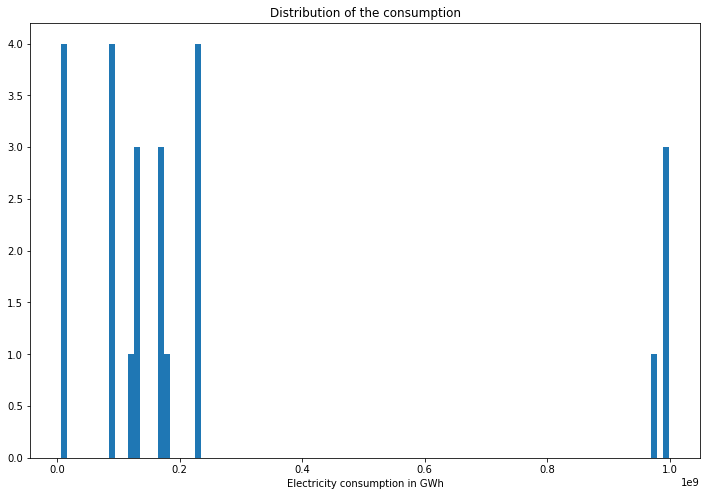

In [50]:
plt.figure(figsize=(12,8))
plt.hist(ndf['total_mw'], bins=100)
plt.title("Distribution of the consumption")
plt.xlabel("Electricity consumption in GWh")
plt.show()

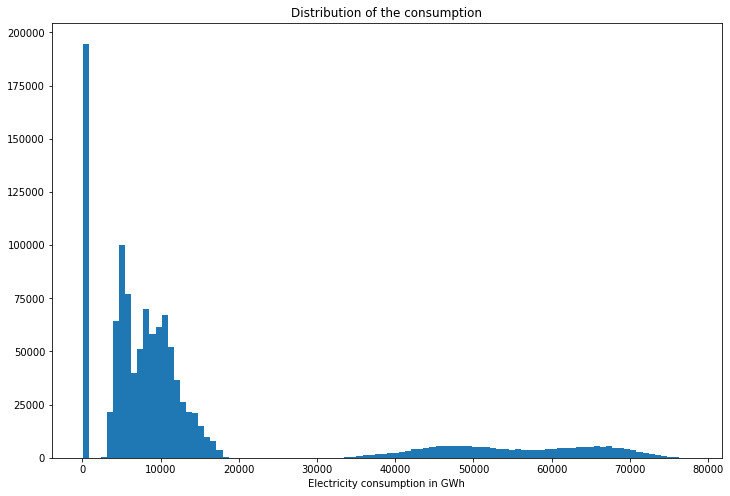

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.hist(df['load_actual_entsoe_transparency'], bins=100)
plt.title("Distribution of the consumption")
plt.xlabel("Electricity consumption in GWh")
plt.show()

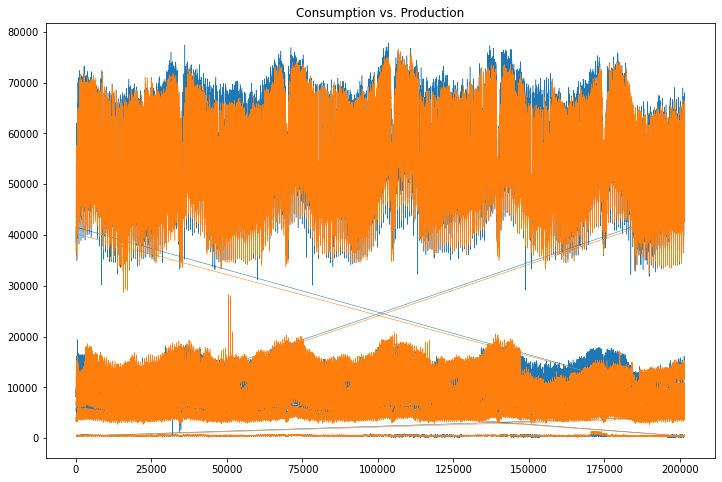

In [12]:
plt.figure(figsize=(12,8))
plt.plot(df['load_actual_entsoe_transparency'], linewidth = 0.5)
plt.plot(df['load_forecast_entsoe_transparency'], linewidth = 0.5)
plt.title("Consumption vs. Production")
plt.show()

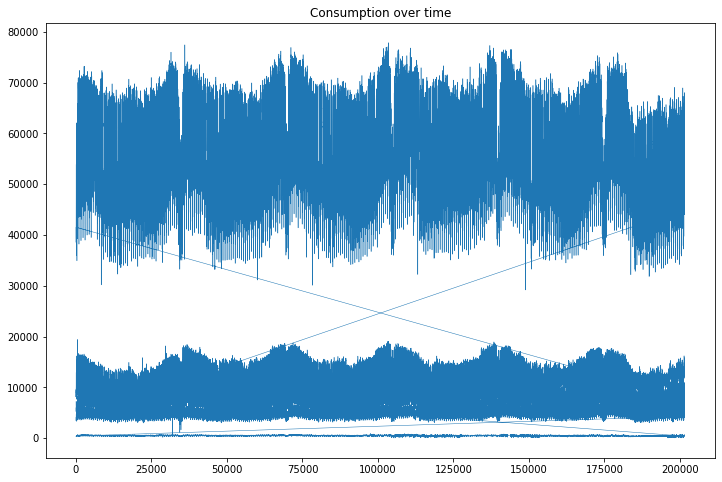

In [13]:
plt.figure(figsize=(12,8))
plt.plot(df['load_actual_entsoe_transparency'], linewidth = 0.5)
plt.title("Consumption over time")
plt.show()

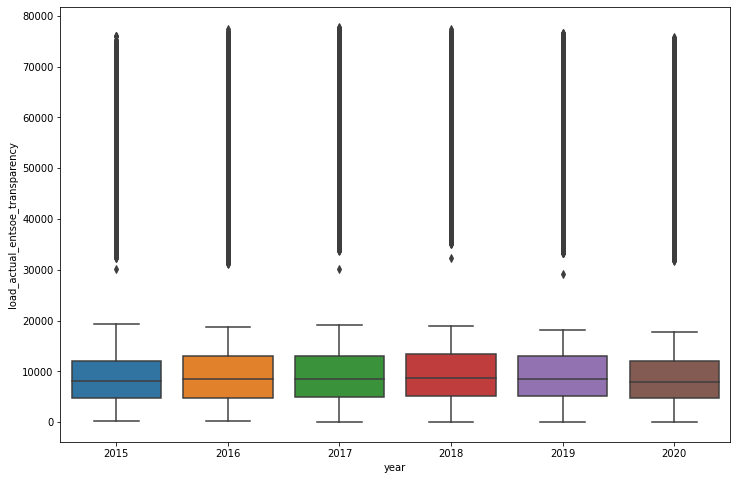

In [23]:
#df.set_index('utc_timestamp', inplace=True)
import seaborn as sns
df['year'] = df.index.year
df['month'] = df.index.month
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='year', y='load_actual_entsoe_transparency')
plt.show()